In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qcc.quantum.qiskit.convolution import Convolution
from qcc.quantum.qiskit.c2q import C2QAnsatz, C2Q

num_qubits = 3

qc = QuantumCircuit(num_qubits)
qc.compose(C2Q(num_qubits), inplace=True)
qc.assign_parameters(np.arange(qc.num_parameters), inplace=True)

qc.decompose().decompose().draw('mpl', reverse_bits=True)

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qcc.quantum.qiskit.convolution import Convolution
from qcc.quantum.qiskit.c2q import C2QAnsatz, C2Q

num_qubits = 3

qc = QuantumCircuit(num_qubits*2 + 5)
qc.compose(Convolution([2**num_qubits, 2**num_qubits], (8, 4)), inplace=True)
qc.assign_parameters(np.arange(qc.num_parameters), inplace=True)

qc.decompose().draw('mpl', reverse_bits=True)

In [7]:
import torch
import numpy as np

from qcc.quantum.qiskit.qcnn import QCNN

qcnn = QCNN.from_dims([16, 16], num_layers=3)

test = qcnn.module
qnn = test.neural_network

predictions = test(torch.rand((1, test.neural_network.num_inputs)))

print(predictions)

tensor([[0.4974, 0.5026]], grad_fn=<_TorchNNFunctionBackward>)


In [9]:
qnn.backward(torch.rand((1, qnn.num_inputs)), torch.rand((1, qnn.num_weights)))

(None,
 array([[[ 4.43277797e-02,  2.04664161e-02,  1.88222065e-02,
           7.08865723e-03,  5.37179577e-02,  7.56115876e-02,
           5.49343763e-02,  1.25938653e-01,  1.02058104e-01,
           1.10441335e-02,  2.86289575e-02,  8.87923719e-03,
          -1.12993068e-02, -1.85603637e-02, -2.04592044e-02,
           8.26191711e-03, -1.39788723e-02, -2.18475611e-02,
          -1.09280330e-02, -4.42976816e-02, -4.63993330e-02,
           3.46363677e-02, -2.79662311e-02, -6.07881742e-02,
          -1.15743534e-02, -3.90114831e-02, -3.84040537e-02,
           9.84756851e-03, -1.84233749e-02, -1.85672136e-02,
          -2.26202890e-02, -2.01028227e-02, -2.97889082e-02,
          -2.46380981e-02, -5.37364522e-03, -1.27303230e-04,
           9.20531456e-03, -2.46695060e-02, -3.49397456e-02,
           3.98757440e-03, -1.49058848e-02,  1.70333256e-02,
          -7.35574573e-03, -2.02745806e-16,  1.95830703e-03,
          -2.74443754e-02, -3.10685272e-03, -1.12162277e-02,
          -2.6721

In [1]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, MSELoss

optimizer = Adam(test.parameters())

optimizer.zero_grad()
cost = CrossEntropyLoss()(predictions, torch.tensor([1]))
cost.backward()
optimizer.step()

NameError: name 'test' is not defined

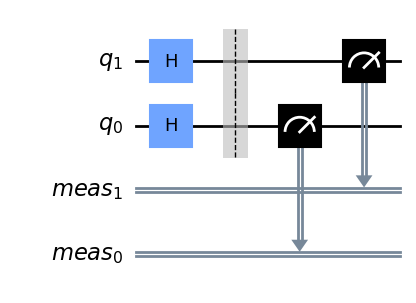

In [11]:
from qiskit import QuantumCircuit, Aer

qc = QuantumCircuit(2)

qc.h([0, 1])
qc.measure_all()

qc.draw('mpl', reverse_bits=True)

In [12]:
from qiskit.result import sampled_expectation_value

backend = Aer.get_backend("aer_simulator")

result = backend.run(qc, shots=10000).result()

In [14]:
counts = result.get_counts()

print(counts)

{'01': 2456, '00': 2509, '11': 2511, '10': 2524}


In [47]:
sampled_expectation_value({
    "00": 1,
    "01": 1,
    "10": 1,
    "11": 1,
}, oper="00")

0.25

In [1]:
import pennylane as qml

dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def my_quantum_function(x, y):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(y, wires=1)
    qml.CNOT(wires=[0, 2])
    return qml.expval(qml.PauliZ(0) @ qml.PauliX(2))

my_quantum_function(1, 2)

tensor(0., requires_grad=True)